<h1><center>IMT2118 - Ciencia de Datos Geoespaciales (2024-1) </center></h1>
<h2><center>Proyecto:   </center></h2>

### Imports

In [1]:
import pandas as pd
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import geemap, ee
from shapely.geometry import LineString, Point
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from esda.moran import Moran_Local
from shapely.ops import nearest_points
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors
from libpysal.weights import Queen
import geemap.foliumap as geemap



# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

### Lectura de Datos

In [2]:
stgo = gpd.read_file("Datos/santiago_urbano.gpkg")
roi_shapely = stgo.union_all()

In [3]:
Censo_2017 = gpd.read_file("Datos/Censo_2017.gpkg")
Comercio = gpd.read_file("Datos/Comercio.gpkg")
Ejes = gpd.read_file("Datos/Ejes.gpkg")
Limite_Comunal = gpd.read_file("Datos/Limite_Comunal.gpkg")
Paraderos = gpd.read_file("Datos/paraderos_frecuentes.gpkg")


In [4]:

zonas = gpd.read_file("Datos/datosZonas_Stgo_C2017.gpkg")
zonas = zonas.to_crs(Limite_Comunal.crs)

# Usar el centroide de cada zona para asignar la comuna, así evitamos problemas de polígonos limítrofes
zonas['centroide'] = zonas.geometry.centroid
zonas_centros = zonas.set_geometry('centroide')

# Hacer el join usando los centroides
zonas_centros = zonas_centros.sjoin(Limite_Comunal[['comuna', 'geometry']], how='left', predicate='within')

# Asignar la comuna encontrada por el centroide a la tabla original
zonas['comuna'] = zonas_centros['comuna'].values

C:\Users\frncc\AppData\Local\Temp\ipykernel_15424\1792528882.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zonas['centroide'] = zonas.geometry.centroid


In [5]:
Censo_2017 = Censo_2017[Censo_2017.geometry.within(roi_shapely)]
Comercio = Comercio[Comercio.geometry.within(roi_shapely)]
Ejes = Ejes[Ejes.geometry.within(roi_shapely)]
Paraderos = Paraderos[Paraderos.geometry.within(roi_shapely)]

### Comunas

Filtramos que el Limite comunal solo incluya nuestra zona de interes

In [6]:
Limite_Comunal['geometry'] = Limite_Comunal.geometry.intersection(roi_shapely)
Limite_Comunal = Limite_Comunal[~Limite_Comunal.is_empty]

## Metro

In [7]:
ee.Initialize()

# Leer archivo estaciones (asegúrate que tenga columnas stop_lat y stop_lon)
df = pd.read_csv("Datos/estaciones_metro.csv", decimal=',')

# Reemplazar comas por puntos si es necesario
for col in ['stop_lat', 'stop_lon']:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# Crear geometría POINT para cada estación
df['geometry'] = df.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)

# Convertir a GeoDataFrame
gdf_estaciones = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Asignar colores a líneas (si tienes columna para línea, por ejemplo 'linea' o extraer de stop_id)
# Aquí un ejemplo para extraer línea del stop_id si está codificada tipo "LH-L1-V1"
def obtener_linea(stop_id):
    if pd.isna(stop_id):
        return None
    parts = stop_id.split('-')
    # Ejemplo: LH-L1-V1 => toma 'L1' y elimina 'L' para quedar solo número
    if len(parts) > 1:
        return parts[1].replace('L','')
    return None

gdf_estaciones['linea'] = gdf_estaciones['stop_id'].apply(obtener_linea).astype(str)

colores_lineas = {
    '1': 'E1251B',
    '2': 'FFD600',
    '3': '682600',
    '4': '0072BC',
    '4A': '5FAEE2',
    '5': '365A05',
    '6': 'B303DF'
}

gdf_estaciones['color'] = gdf_estaciones['linea'].map(colores_lineas).fillna('000000')  # negro si no asigna

# Crear features estilizados para Earth Engine
features = []
for _, row in gdf_estaciones.iterrows():
    geom = geemap.geopandas_to_ee(gpd.GeoDataFrame([row], crs="EPSG:4326")).geometry()
    feature = ee.Feature(geom).set('style', {
        'color': row['color'],
        'radius': 6,
        'fillColor': row['color'],
        'fillOpacity': 1,
        'stroke': True,
        'strokeWidth': 1,
        'strokeColor': row['color']
    })
    features.append(feature)

fc = ee.FeatureCollection(features)

# Visualizar en geemap
m_estaciones = geemap.Map(center=[-33.45, -70.65], zoom=12)
m_estaciones.add_gdf(Limite_Comunal, "Comunas Santiago Urbano", style={'color': 'black', 'fillOpacity': 0.2, 'weight': 1.5})
m_estaciones.addLayer(fc.style(**{'styleProperty': 'style'}), {}, 'Estaciones de Metro')
m_estaciones

In [8]:
Metro = gdf_estaciones.copy()
# Cruce espacial para asignar comuna a cada estación
gdf_estaciones_comunas = gpd.sjoin(gdf_estaciones, Limite_Comunal, how='left', predicate='within')

# Conteo de estaciones por comuna
conteo = gdf_estaciones_comunas['comuna'].value_counts().sort_index()

# Comunas que no tienen ninguna estación
comunas_todas = Limite_Comunal['comuna'].unique()
comunas_sin_metro = set(comunas_todas) - set(conteo.index)

print("Comunas sin estaciones de metro:")
print(sorted(comunas_sin_metro))


Comunas sin estaciones de metro:
['CERRO NAVIA', 'COLINA', 'HUECHURABA', 'LA PINTANA', 'LAMPA', 'LO BARNECHEA', 'LO ESPEJO', 'RENCA', 'VITACURA']


In [9]:
zonas

NZONA  EDAD_65YMA  INMIGRANTE  PERSONAS  HOMBRES  MUJERES  PUEBLO  \
0         0           4          11        78       39       16       7   
1         1           0           0        57       26       16       4   
2         2         473          40      5780     2842     2938     870   
3         3         264         204      1903      948      955     176   
4         4         202          74      1119      537      582     105   
...     ...         ...         ...       ...      ...      ...     ...   
1612   1612         271         260      1894      956      938     149   
1613   1613          87         317      1677      847      830     132   
1614   1614         303        1199      3997     2065     1932     437   
1615   1615         107         221      1218      573      645      96   
1616   1616         202         210      2052      976     1076      40   

                                               geometry  \
0     POLYGON ((-70.72358 -33.32546, -70.72397 -33.3...   
1     POLYGON ((-70.72395 -33.31337, -70.72393 -33.3...   
2     POLYGON ((-70.64114 -33.56398, -70.64121 -33.5...   
3     POLYGON ((-70.65571 -33.47856, -70.65575 -33.4...   
4     POLYGON ((-70.61064 -33.50835, -70.61061 -33.5...   
...                                                 ...   
1612  POLYGON ((-70.63944 -33.44325, -70.63923 -33.4...   
1613  POLYGON ((-70.64458 -33.44962, -70.64458 -33.4...   
1614  POLYGON ((-70.66477 -33.44733, -70.6648 -33.44...   
1615  POLYGON ((-70.66026 -33.44732, -70.66023 -33.4...   
1616  POLYGON ((-70.5275 -33.37744, -70.52764 -33.37...   

                        centroide               comuna  
0     POINT (-70.72955 -33.32173)                LAMPA  
1      POINT (-70.73391 -33.3126)                LAMPA  
2     POINT (-70.64371 -33.56233)           LA PINTANA  
3     POINT (-70.66347 -33.47735)  PEDRO AGUIRRE CERDA  
4     POINT (-70.60543 -33.51101)           LA FLORIDA  
...                           ...                  ...  
1612  POINT (-70.63915 -33.44406)             SANTIAGO  
1613   POINT (-70.64348 -33.4485)             SANTIAGO  
1614  POINT (-70.66887 -33.44993)             SANTIAGO  
1615  POINT (-70.66243 -33.44816)             SANTIAGO  
1616  POINT (-70.52894 -33.37718)             VITACURA  

[1617 rows x 10 columns]

In [10]:
# Crear personas_por_comuna agrupando por nombre de comuna
personas_por_comuna = zonas.groupby('comuna')['PERSONAS'].sum()

# Filtrar las comunas sin metro en personas_por_comuna
personas_sin_metro = personas_por_comuna[personas_por_comuna.index.isin(comunas_sin_metro)]
print(personas_sin_metro)
print(f"Total de personas en comunas sin metro: {personas_sin_metro.sum()}")

comuna
CERRO NAVIA     124823
HUECHURABA       96020
LA PINTANA      177017
LAMPA              135
LO BARNECHEA    102014
LO ESPEJO        99328
RENCA           128761
VITACURA         88125
Name: PERSONAS, dtype: int64
Total de personas en comunas sin metro: 816223


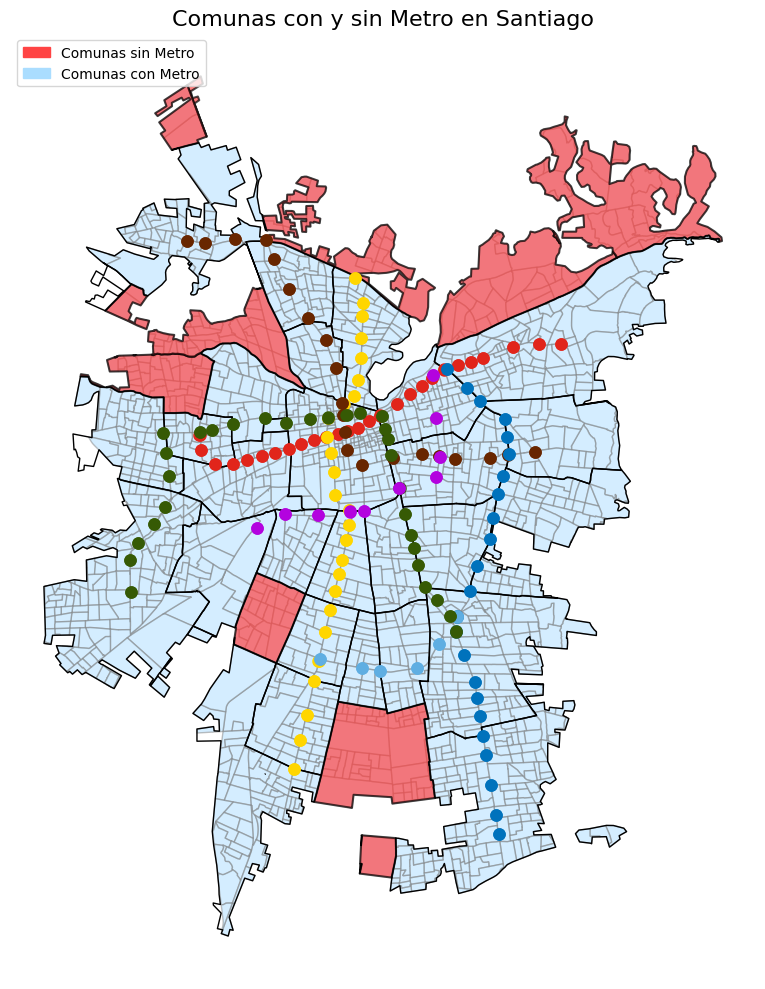

In [11]:
Limite_Comunal['sin_metro'] = Limite_Comunal['comuna'].str.upper().isin(comunas_sin_metro)

fig, ax = plt.subplots(figsize=(10, 10))

# Zonas censales
zonas.plot(ax=ax, color='#aaddff', edgecolor='gray', alpha=0.5, label='Zonas Censo 2017')

# Comunas sin metro
Limite_Comunal[Limite_Comunal['sin_metro']].plot(
    ax=ax, color='#ff4444', edgecolor='black', linewidth=1.5, alpha=0.7, label='Comunas sin Metro'
)

# Comunas con metro
Limite_Comunal[~Limite_Comunal['sin_metro']].plot(
    ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=1, label='Comunas con Metro'
)

# Líneas de metro
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(
        ax=ax, color=f'#{color}', linewidth=3, label=f'Línea {linea}'
    )

# Leyenda manual
leyenda = [
    mpatches.Patch(color='#ff4444', label='Comunas sin Metro'),
    mpatches.Patch(color='#aaddff', label='Comunas con Metro')
]

ax.legend(handles=leyenda, loc='upper left', fontsize=10)
ax.set_title('Comunas con y sin Metro en Santiago', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


## Densidad Poblacional

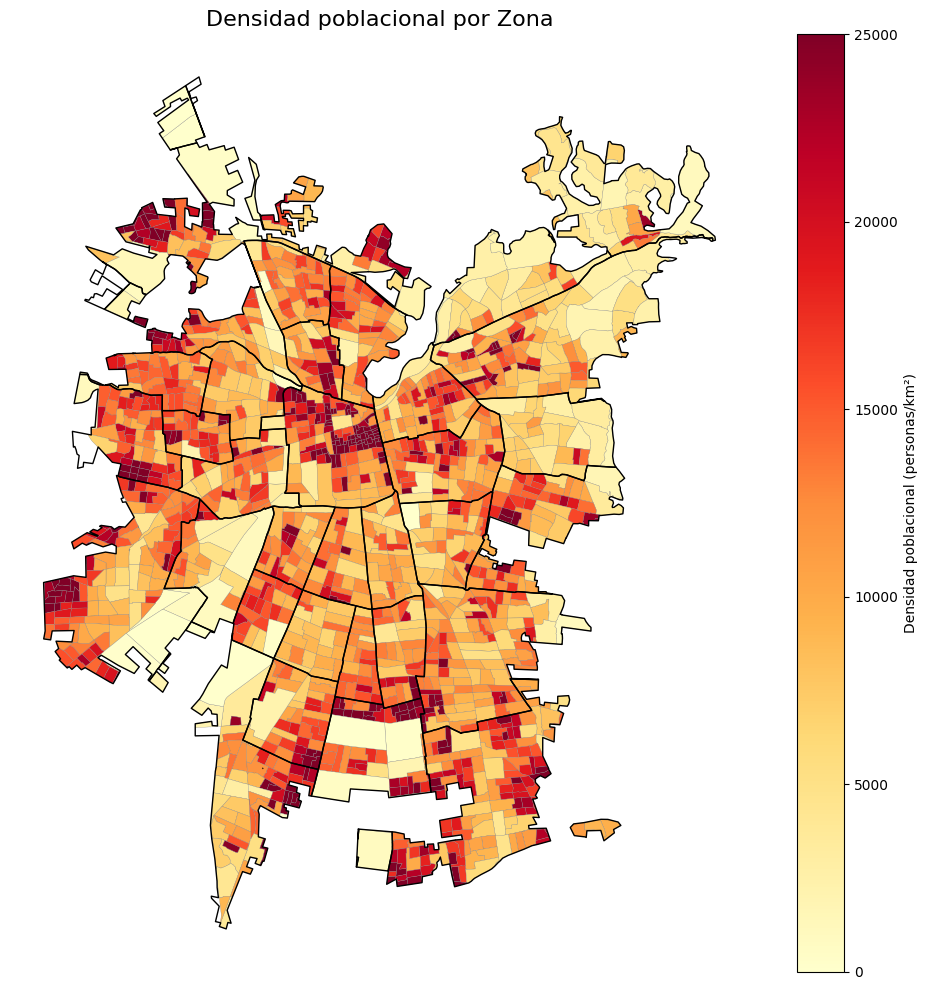

In [12]:
zonas_proj = zonas.to_crs(epsg=32719)
zonas['area_km2'] = zonas_proj.geometry.area / 1e6

zonas['densidad'] = zonas['PERSONAS'] / zonas['area_km2']

fig, ax = plt.subplots(figsize=(10, 10))

vmax = 25000
"""
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(ax=ax, color=f'#{color}', linewidth=5, label=f'Línea {linea}')

"""
zonas.plot(
    column='densidad', ax=ax, cmap='YlOrRd', legend=True, 
    legend_kwds={'label': "Densidad poblacional (personas/km²)"},
    edgecolor='gray', linewidth=0.2, vmax=vmax)

Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title('Densidad poblacional por Zona', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

C:\Users\frncc\AppData\Local\Temp\ipykernel_15424\509704801.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_1km_union = buffer_1km.unary_union
C:\Users\frncc\AppData\Local\Temp\ipykernel_15424\509704801.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


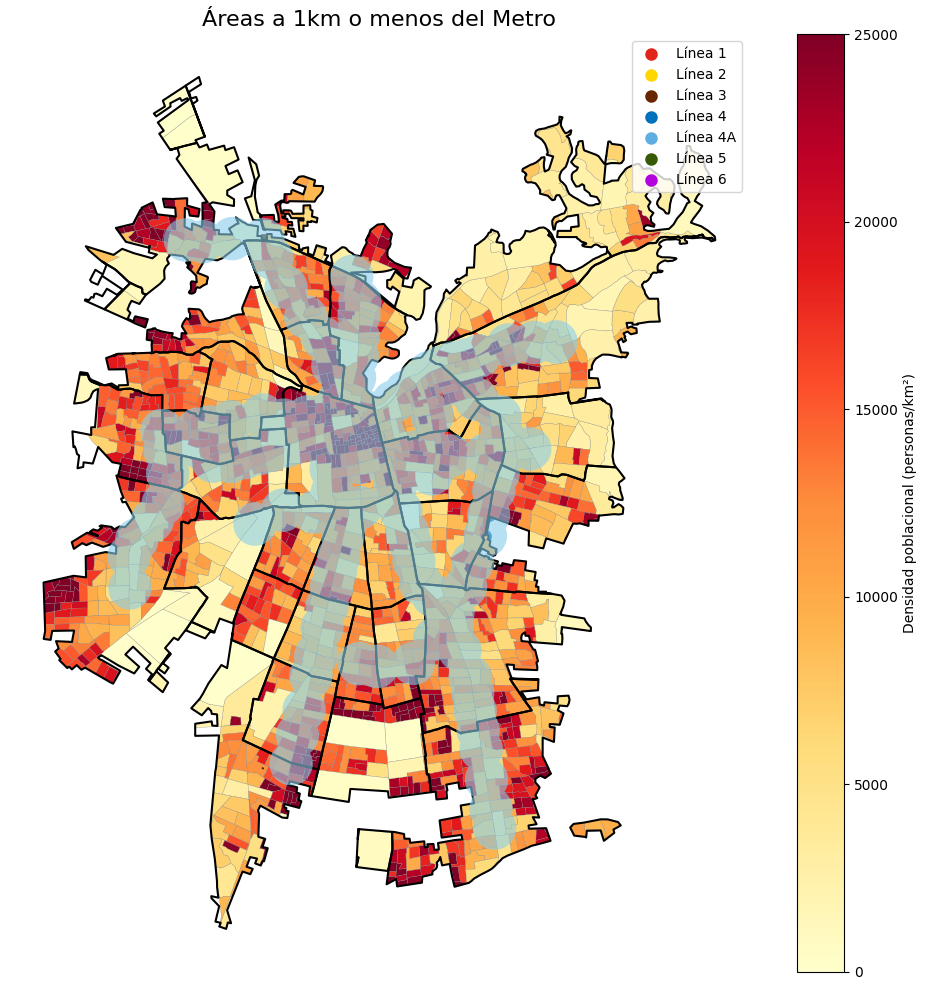

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(ax=ax, color=f'#{color}', linewidth=3, label=f'Línea {linea}')

zonas.plot(
    column='densidad', ax=ax, cmap='YlOrRd', legend=True, 
    legend_kwds={'label': "Densidad poblacional (personas/km²)"},
    edgecolor='gray', linewidth=0.2, vmax=vmax)

Limite_Comunal.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, label='Límite Comunal')

Metro_proj = Metro.to_crs(epsg=32719)
buffer_1km = Metro_proj.buffer(1000)
buffer_1km_union = buffer_1km.unary_union
buffer_1km_wgs = gpd.GeoSeries([buffer_1km_union], crs="EPSG:32719").to_crs(epsg=4326)

buffer_1km_wgs.plot(ax=ax, color='skyblue', alpha=0.6, label='<= 1km del Metro')

ax.set_title('Áreas a 1km o menos del Metro', fontsize=16)
ax.axis('off')


handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\frncc\AppData\Local\Temp\ipykernel_15424\2080862911.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_zonas = Queen.from_dataframe(zonas)
C:\Users\frncc\AppData\Roaming\Python\Python313\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


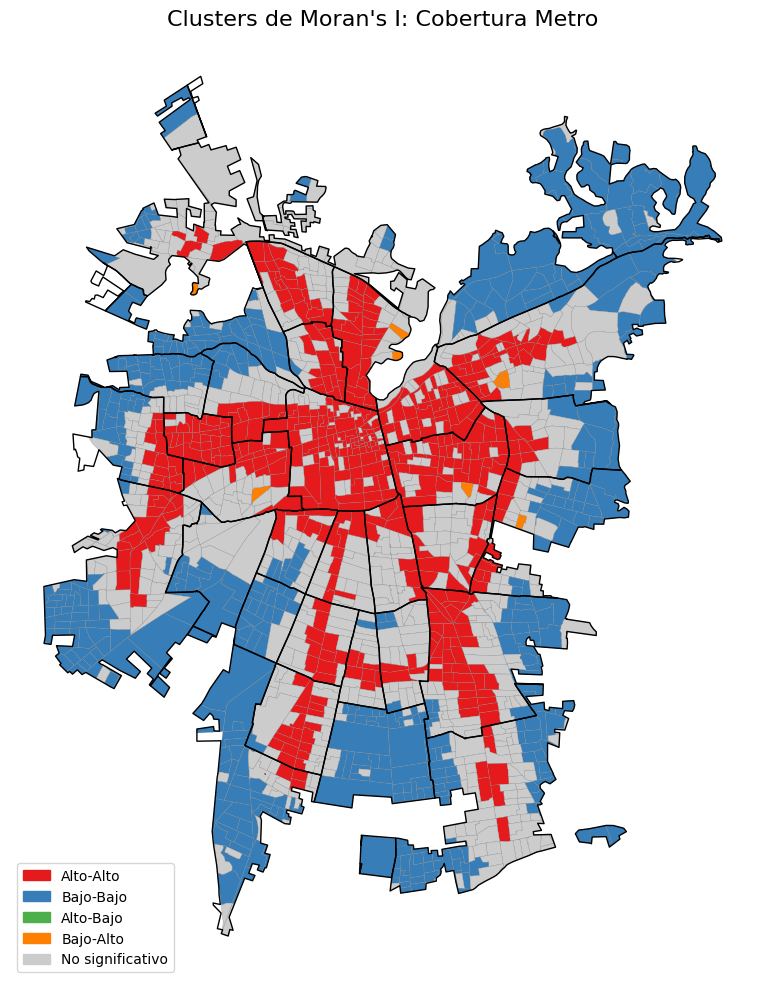

In [14]:
zonas['cerca_metro'] = zonas.geometry.intersects(buffer_1km_wgs.iloc[0]).astype(int)

w_zonas = Queen.from_dataframe(zonas)


moran_local_metro = Moran_Local(zonas['cerca_metro'], w_zonas)

zonas['cluster_metro'] = 'No significativo'
zonas.loc[(moran_local_metro.q == 1) & (moran_local_metro.p_sim < 0.05), 'cluster_metro'] = 'Alto-Alto'
zonas.loc[(moran_local_metro.q == 2) & (moran_local_metro.p_sim < 0.05), 'cluster_metro'] = 'Bajo-Alto'
zonas.loc[(moran_local_metro.q == 3) & (moran_local_metro.p_sim < 0.05), 'cluster_metro'] = 'Bajo-Bajo'
zonas.loc[(moran_local_metro.q == 4) & (moran_local_metro.p_sim < 0.05), 'cluster_metro'] = 'Alto-Bajo'

cluster_colors = {
    'Alto-Alto': '#e41a1c',
    'Bajo-Bajo': '#377eb8',
    'Alto-Bajo': '#4daf4a',
    'Bajo-Alto': '#ff7f00',
    'No significativo': '#cccccc'
}

fig, ax = plt.subplots(figsize=(10, 10))
zonas.plot(ax=ax, color=zonas['cluster_metro'].map(cluster_colors), edgecolor='gray', linewidth=0.2)
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Clusters de Moran's I: Cobertura Metro", fontsize=16)
ax.axis('off')

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in cluster_colors.items()]
ax.legend(handles=legend_patches, loc='lower left', fontsize=10)

plt.tight_layout()
plt.show()

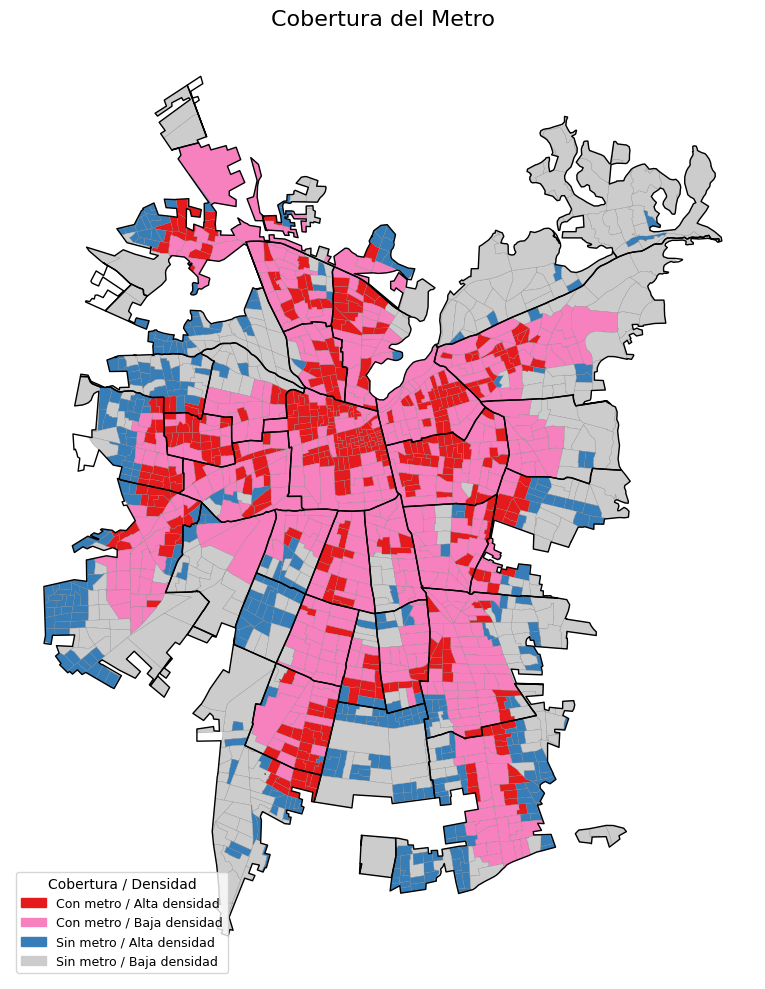

In [15]:
zonas['dens_q'] = pd.qcut(zonas['densidad'], 2, labels=['Baja densidad', 'Alta densidad'])
zonas['metro_q'] = zonas['cerca_metro'].map({0: 'Sin metro', 1: 'Con metro'})
zonas['combo'] = zonas['metro_q'].astype(str) + " / " + zonas['dens_q'].astype(str)

# Paleta de colores combinada
palette_combo = {
    'Con metro / Alta densidad': '#e41a1c',
    'Con metro / Baja densidad': '#f781bf',
    'Sin metro / Alta densidad': '#377eb8',
    'Sin metro / Baja densidad': '#cccccc'
}

fig, ax = plt.subplots(figsize=(10, 10))
zonas.plot(ax=ax, color=zonas['combo'].map(palette_combo), edgecolor='gray', linewidth=0.2)
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Cobertura del Metro", fontsize=16)
ax.axis('off')

legend_patches = [mpatches.Patch(color=color, label=label) for label, color in palette_combo.items()]
ax.legend(handles=legend_patches, loc='lower left', fontsize=9, title='Cobertura / Densidad')

plt.tight_layout()
plt.show()

C:\Users\frncc\AppData\Local\Temp\ipykernel_15424\468955831.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zonas['centroide'] = zonas.geometry.centroid
C:\Users\frncc\AppData\Local\Temp\ipykernel_15424\468955831.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
C:\Users\frncc\AppData\Local\Temp\ipykernel_15424\468955831.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


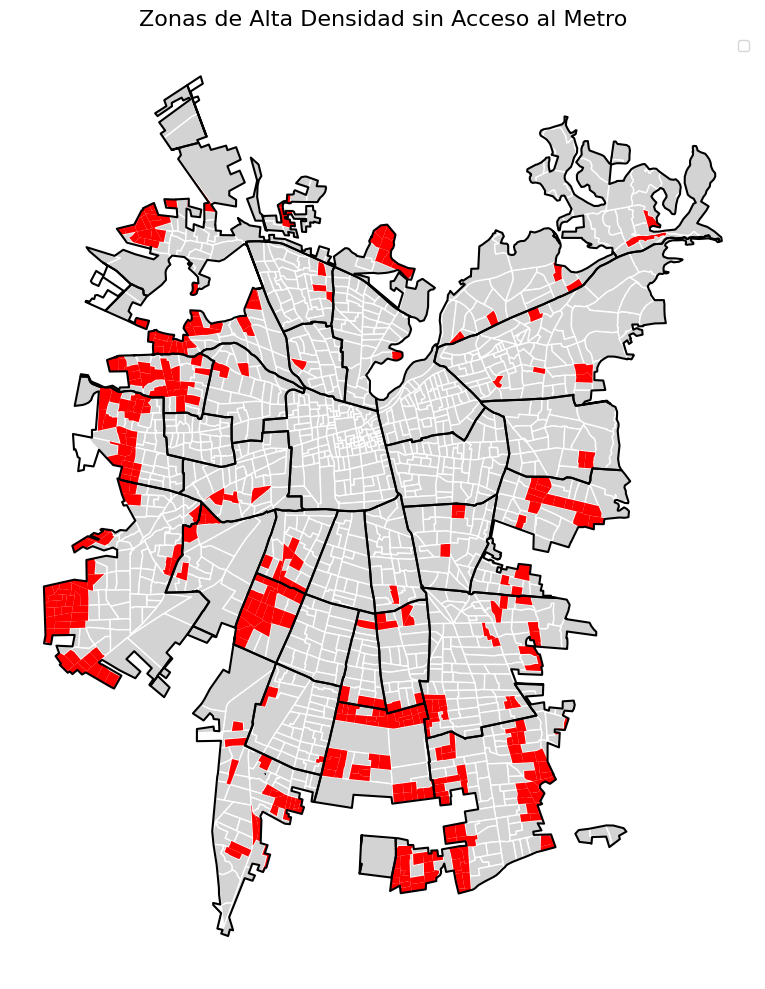

In [16]:
zonas['centroide'] = zonas.geometry.centroid
zonas_criticas = zonas[(zonas['dens_q'] == 'Alta densidad') & (zonas['cerca_metro'] == 0)]

fig, ax = plt.subplots(figsize=(10, 10))
zonas.plot(ax=ax, facecolor='lightgray', edgecolor='white')
zonas_criticas.plot(ax=ax, color='red', markersize=30, label='Alta densidad sin cobertura')
Limite_Comunal.boundary.plot(ax=ax, color='black')

ax.set_title("Zonas de Alta Densidad sin Acceso al Metro", fontsize=16)
ax.legend()
ax.axis('off')
plt.tight_layout()
plt.show()


In [17]:
# Calcular la cantidad total de personas en zonas de alta densidad sin metro
total_personas_zonas_criticas = zonas_criticas['PERSONAS'].sum()
print(f"Cantidad de personas en zonas de alta densidad sin metro: {total_personas_zonas_criticas}")

Cantidad de personas en zonas de alta densidad sin metro: 1520095


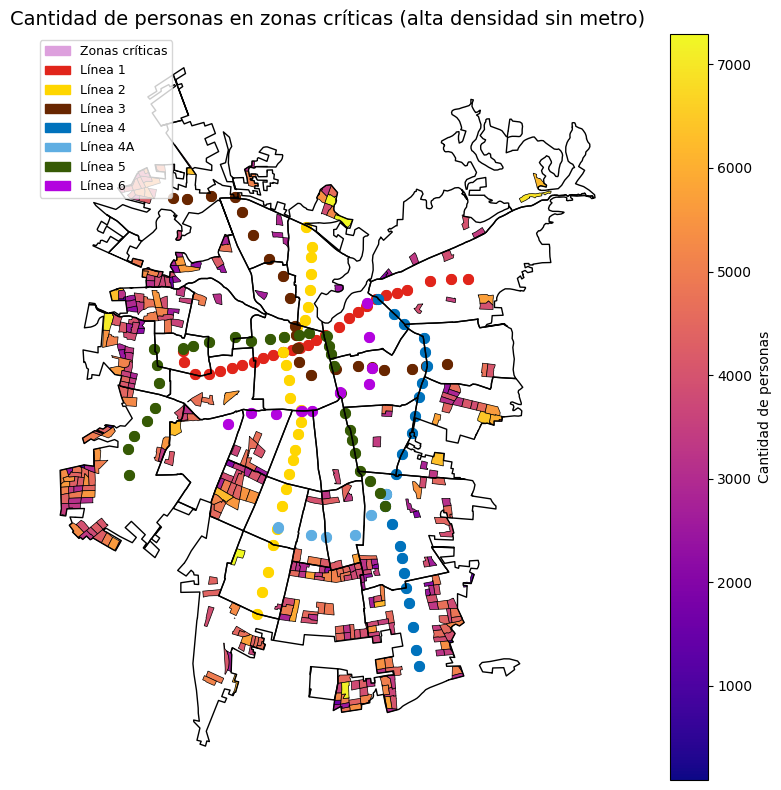

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

vmin = zonas_criticas['PERSONAS'].min()
vmax = zonas_criticas['PERSONAS'].max()

zonas_criticas.plot(
    column='PERSONAS', ax=ax, cmap='plasma', legend=True,
    legend_kwds={'label': "Cantidad de personas"},
    edgecolor='black', linewidth=0.5, vmin=vmin, vmax=vmax
)

# Agregar líneas de metro
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(
        ax=ax, color=f'#{color}', linewidth=2, label=f'Línea {linea}'
    )

Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title('Cantidad de personas en zonas críticas (alta densidad sin metro)', fontsize=14)
ax.axis('off')

leyenda = [
    mpatches.Patch(color='plum', label='Zonas críticas'),
]
for linea, color in colores_lineas.items():
    leyenda.append(mpatches.Patch(color=f'#{color}', label=f'Línea {linea}'))
ax.legend(handles=leyenda, loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

In [19]:

# Proyectar a coordenadas en metros (por ejemplo, EPSG:32719)
zonas_criticas_proj = zonas_criticas.to_crs(epsg=32719)
zonas_criticas_proj['x'] = zonas_criticas_proj.geometry.centroid.x
zonas_criticas_proj['y'] = zonas_criticas_proj.geometry.centroid.y

coords = zonas_criticas_proj[['x', 'y']].values

# eps=1000 significa 1 km, ajusta según lo que consideres razonable
db = DBSCAN(eps=1000, min_samples=2).fit(coords)
zonas_criticas['cluster_id'] = db.labels_


c:\Program Files\Python313\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [20]:
# Asegurarse de que zonas_criticas_proj tenga la columna 'cluster_id'
if 'cluster_id' not in zonas_criticas_proj.columns:
	zonas_criticas_proj['cluster_id'] = db.labels_

# Calcular la suma de personas por cluster
cluster_personas = zonas_criticas.groupby('cluster_id')['PERSONAS'].sum().sort_values(ascending=False)

# Crear un diccionario de mapeo: cluster_id original -> nuevo cluster_id ordenado
cluster_id_map = {old: new for new, old in enumerate(cluster_personas.index)}

# Reasignar los cluster_id en zonas_criticas y zonas_criticas_proj, rellenando NaN con -1 (ruido)
zonas_criticas['cluster_id'] = zonas_criticas['cluster_id'].map(cluster_id_map).fillna(-1).astype(int)
zonas_criticas_proj['cluster_id'] = zonas_criticas_proj['cluster_id'].map(cluster_id_map).fillna(-1).astype(int)

c:\Program Files\Python313\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


C:\Users\frncc\AppData\Local\Temp\ipykernel_15424\2886067492.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(cluster_ids_ordenados))
c:\Program Files\Python313\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


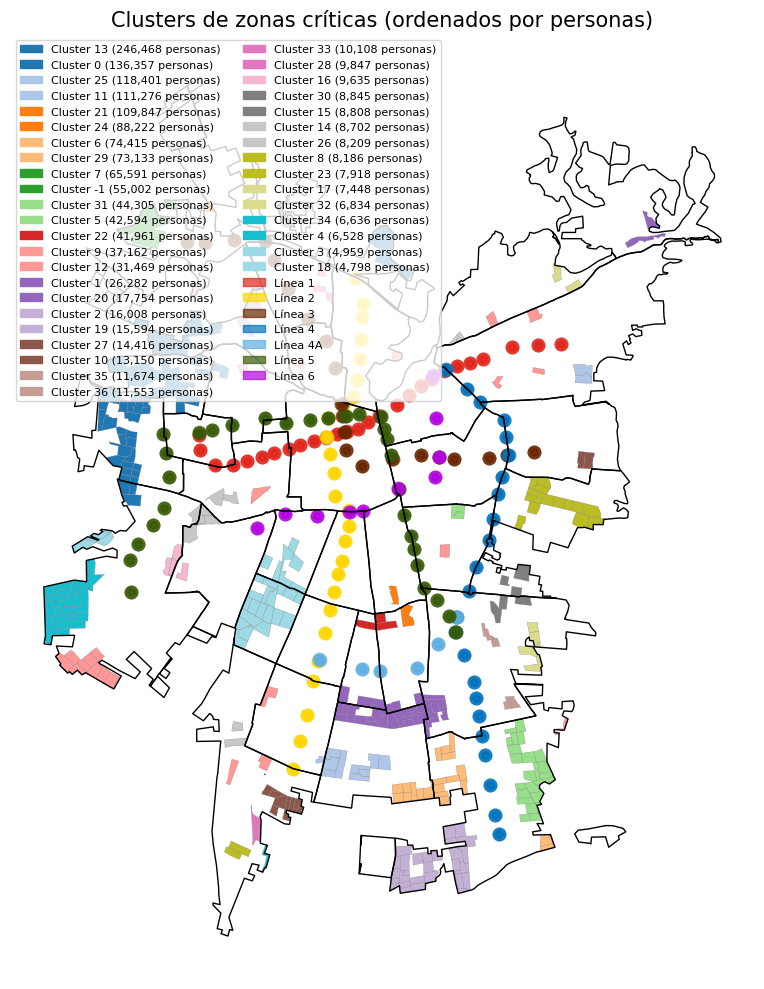

In [21]:
cluster_ids_ordenados = cluster_personas.index.tolist()

# Crear un nuevo colormap ordenado
cmap = cm.get_cmap('tab20', len(cluster_ids_ordenados))
color_dict = {cid: mcolors.to_hex(cmap(i)) for i, cid in enumerate(cluster_ids_ordenados)}

# Asignar color a cada zona crítica según el nuevo orden de cluster_id
zonas_criticas['color_cluster'] = zonas_criticas['cluster_id'].map(color_dict)
zonas_criticas['color_cluster'] = zonas_criticas['color_cluster'].fillna('#cccccc')

fig, ax = plt.subplots(figsize=(10, 10))
zonas_criticas.plot(ax=ax, color=zonas_criticas['color_cluster'], edgecolor='gray', linewidth=0.2)

for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(ax=ax, color=f'#{color}', linewidth=4, alpha=0.7, label=f'Línea {linea}')

Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)

ax.set_title('Clusters de zonas críticas (ordenados por personas)', fontsize=15)
ax.axis('off')

# Leyenda de clusters ordenada
leyenda = [mpatches.Patch(color=color_dict[cid], label=f'Cluster {cid} ({cluster_personas[cid]:,} personas)') for cid in cluster_ids_ordenados]
for linea, color in colores_lineas.items():
    leyenda.append(mpatches.Patch(color=f'#{color}', label=f'Línea {linea}', alpha=0.7))
ax.legend(handles=leyenda, loc='upper left', fontsize=8, ncol=2)

plt.tight_layout()
plt.show()


In [22]:
import geemap.foliumap as geemap

# Crear un GeoDataFrame solo con las columnas necesarias
zonas_criticas_popup = zonas_criticas[['PERSONAS', 'cluster_id', 'geometry']].copy()
zonas_criticas_popup['cluster_id'] = zonas_criticas_popup['cluster_id'].astype(str)

# Crear el mapa centrado en Santiago
m = geemap.Map(center=[-33.5, -70.65], zoom=11)

# Añadir límites comunales
m.add_gdf(Limite_Comunal, layer_name='Límite Comunal', style={'color': 'black', 'weight': 1, 'fillOpacity': 0})

# Añadir las líneas de metro al mapa
for linea, color in colores_lineas.items():
    m.add_gdf(
        Metro[Metro['linea'] == linea],
        layer_name=f'Línea {linea}',
        style={'color': f'#{color}', 'weight': 4, 'opacity': 0.8}
    )
# Añadir las zonas críticas con popup
m.add_gdf(
    zonas_criticas_popup,
    layer_name='Zonas críticas',
    style_function=lambda x: {
        'fillColor': zonas_criticas.loc[zonas_criticas['PERSONAS'] == x['properties']['PERSONAS']]['color_cluster'].values[0]
        if 'color_cluster' in zonas_criticas.columns else '#cccccc',
        'color': 'gray',
        'weight': 0.5,
        'fillOpacity': 0.7
    }
)
m

In [23]:
# Total de zonas y población
total_zonas = len(zonas)
total_poblacion = zonas['PERSONAS'].sum()

# Zonas cubiertas y no cubiertas
cubiertas = zonas[zonas['cerca_metro'] == 1]
no_cubiertas = zonas[zonas['cerca_metro'] == 0]

n_cubiertas = len(cubiertas)
n_no_cubiertas = len(no_cubiertas)

pob_cubierta = cubiertas['PERSONAS'].sum()
pob_no_cubierta = no_cubiertas['PERSONAS'].sum()

# Porcentaje de población cubierta
porcentaje_cubierta = pob_cubierta / total_poblacion * 100
porcentaje_no_cubierta = pob_no_cubierta / total_poblacion * 100

print(pob_cubierta, f"          ", pob_no_cubierta)
print(porcentaje_cubierta, porcentaje_no_cubierta)

3201628            2665195
54.57175033233489 45.428249667665106


In [24]:
dens_cubiertas = cubiertas['densidad'].mean()
dens_no_cubiertas = no_cubiertas['densidad'].mean()

comunas_excluidas = no_cubiertas.groupby('comuna')['PERSONAS'].sum().sort_values(ascending=False)
top_comunas = comunas_excluidas.head(3)
top_comunas


comuna
PUENTE ALTO     370095
MAIPU           265802
SAN BERNARDO    204826
Name: PERSONAS, dtype: int64

In [25]:

# Asegurarse de que ambos estén en la misma proyección métrica para medir distancias (por ejemplo, EPSG:32719)
no_cubiertas_proj = no_cubiertas.copy().to_crs(epsg=32719)
gdf_estaciones_proj = gdf_estaciones.to_crs(epsg=32719)

# Obtener los centroides de las zonas no cubiertas
centroides = no_cubiertas_proj.geometry.centroid

# Crear un array de puntos de estaciones de metro
estaciones_points = gdf_estaciones_proj.geometry.unary_union

# Calcular la distancia mínima de cada zona no cubierta a una estación de metro
no_cubiertas_proj['dist_estacion_km'] = centroides.apply(lambda x: x.distance(nearest_points(x, estaciones_points)[1]) / 1000)

# Calcular el promedio
dist_promedio = no_cubiertas_proj['dist_estacion_km'].mean()
print(f"Distancia promedio a la estación de metro más cercana para Zonas no cubiertas: {dist_promedio:.2f} km")


Distancia promedio a la estación de metro más cercana para Zonas no cubiertas: 2.70 km


C:\Users\frncc\AppData\Local\Temp\ipykernel_15424\3270898183.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  estaciones_points = gdf_estaciones_proj.geometry.unary_union


In [26]:
zonas['cluster_metro'].value_counts()

cluster_metro
No significativo    660
Alto-Alto           490
Bajo-Bajo           459
Bajo-Alto             8
Name: count, dtype: int64

## Ejes

In [27]:
# Filtrar los ejes de jerarquía 1 y 2
Ejes_jerarquia = Ejes[Ejes['hierarchy'].isin([1, 2])]

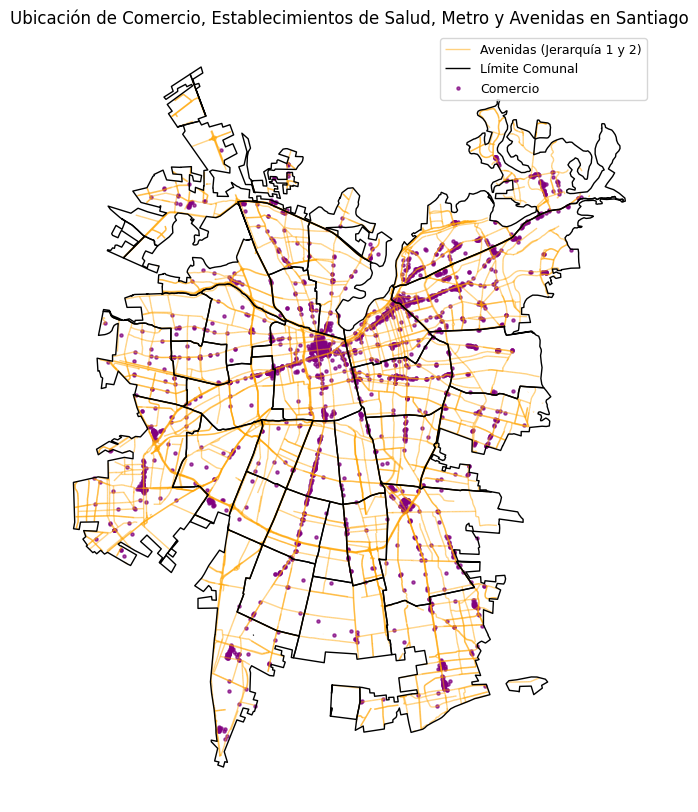

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

# 1. Avenidas (Ejes jerarquía 1 y 2) al fondo
Ejes_jerarquia.plot(ax=ax, color='orange', linewidth=1, alpha=0.5, label='Avenidas (Jerarquía 1 y 2)')

# 3. Límite comunal
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1, label='Límite Comunal')

# 4. Comercio
Comercio.plot(ax=ax, color='purple', markersize=5, alpha=0.7, label='Comercio')

# 5. Establecimientos de Salud

ax.set_title('Ubicación de Comercio, Establecimientos de Salud, Metro y Avenidas en Santiago')
ax.axis('off')

# Leyenda personalizada para evitar duplicados
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), fontsize=9)

plt.show()

C:\Users\frncc\AppData\Local\Temp\ipykernel_15424\1428839149.py:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color='none', edgecolor='black', label='Comunas con Metro'),


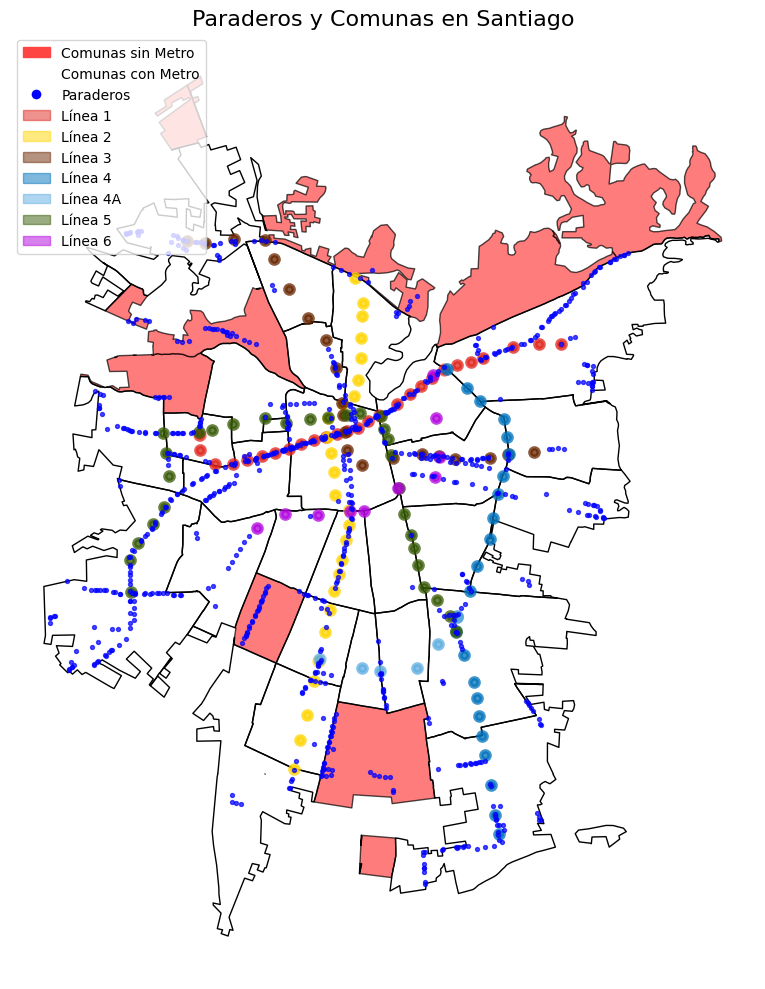

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))

# Comunas sin metro
Limite_Comunal[Limite_Comunal['sin_metro']].plot(
    ax=ax, color='#ff4444', edgecolor='black', linewidth=1, alpha=0.7, label='Comunas sin Metro'
)

# Comunas con metro
Limite_Comunal[~Limite_Comunal['sin_metro']].plot(
    ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=1, label='Comunas con Metro'
)

# Líneas de metro (con alpha)
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(
        ax=ax, color=f'#{color}', linewidth=3, alpha=0.5, label=f'Línea {linea}'
    )

# Paraderos
Paraderos.plot(ax=ax, color='blue', markersize=8, alpha=0.7, label='Paraderos')

ax.set_title('Paraderos y Comunas en Santiago', fontsize=16)
ax.axis('off')

leyenda = [
    mpatches.Patch(color='#ff4444', label='Comunas sin Metro'),
    mpatches.Patch(color='none', edgecolor='black', label='Comunas con Metro'),
    plt.Line2D([0], [0], marker='o', color='w', label='Paraderos', markerfacecolor='blue', markersize=8)
]
for linea, color in colores_lineas.items():
    leyenda.append(mpatches.Patch(color=f'#{color}', label=f'Línea {linea}', alpha=0.5))

ax.legend(handles=leyenda, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

## Imagenes Satelitales

In [32]:
gran_santiago = ee.Geometry.Polygon([
    [[-70.9, -33.8], [-70.9, -33.2], [-70.3, -33.2], [-70.3, -33.8]]
])

def mask_s2_sr_clouds(image):
    cloud_prob = image.select('MSK_CLDPRB')
    cloud_mask = cloud_prob.lt(20)
    return image.updateMask(cloud_mask).copyProperties(image, ["system:time_start"])

def get_annual_composite(year):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterDate(start_date, end_date)
        .filterBounds(gran_santiago)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .map(mask_s2_sr_clouds)
    )
    count = collection.size().getInfo()
    if count == 0:
        print(f"No hay imágenes para el año {year}")
        return None
    return collection.median().clip(gran_santiago)

def ndvi(image):
    return image.normalizedDifference(['B8', 'B4']).rename('NDVI')

def ndbi(image):
    return image.normalizedDifference(['B11', 'B8']).rename('NDBI')

def get_ndvi_ndbi(year):
    img = get_annual_composite(year)
    if img:
        return img.addBands(ndvi(img)).addBands(ndbi(img))
    return None


In [34]:
img_2019 = get_ndvi_ndbi(2019)
img_2024 = get_ndvi_ndbi(2024)

ndvi_diff = img_2024.select('NDVI').subtract(img_2019.select('NDVI')).rename('NDVI_Diff')
ndbi_diff = img_2024.select('NDBI').subtract(img_2019.select('NDBI')).rename('NDBI_Diff')
diff_stack = ndvi_diff.addBands(ndbi_diff)

In [35]:
limite_comunal_ee = geemap.geopandas_to_ee(Limite_Comunal)

zonales_comunas = diff_stack.reduceRegions(
    collection=limite_comunal_ee,
    reducer=ee.Reducer.mean(),
    scale=30
)


estaciones_df = pd.read_csv("Datos/estaciones_metro.csv")
estaciones_df['geometry'] = estaciones_df.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1
)
gdf_estaciones = gpd.GeoDataFrame(estaciones_df, geometry='geometry', crs="EPSG:4326")
estaciones_ee = geemap.geopandas_to_ee(gdf_estaciones)

buffers = estaciones_ee.map(lambda f: f.buffer(1000))
zonales_buffers = diff_stack.reduceRegions(
    collection=buffers,
    reducer=ee.Reducer.mean(),
    scale=30
)

Map = geemap.Map(center=[-33.45, -70.65], zoom=11)

vis_params = {
    'min': -0.5,
    'max': 0.5,
    'palette': [
        '006837', '1a9850', '66bd63', 'ffffbf', 'f46d43', 'd73027', 'a50026'
    ]
}

Map.addLayer(ndbi_diff, vis_params, 'Cambio NDBI 2019–2024')
Map.add_gdf(Limite_Comunal.boundary, layer_name='Límites comunales', style={'color': 'white', 'weight': 1.5})
Map.addLayerControl()
Map


Vemos que mayoritariamente, el desarrollo urbano tiene tendencia hacia las afueras de santiago, puede afectar los años de estudio, que son años de estallido social y pandemia, entonces puede ser una idea importante no centrar el transporte en la zona central o ya urbanizada de santiago, si no que expandir el transporte publico, para tener un mejor acceso a comunas como Colina, Lampa, Buin, Peñaflor y notori

In [ ]:
task = ee.batch.Export.table.toDrive(
    collection=zonales_comunas,
    description='zonales_comunas_ndvi_ndbi',
    folder='gee_exports',
    fileFormat='CSV'
)
task.start()

task2 = ee.batch.Export.table.toDrive(
    collection=zonales_buffers,
    description='zonales_buffers_ndvi_ndbi',
    folder='gee_exports',
    fileFormat='CSV'
)
task2.start()

In [40]:
def get_viirs_annual_mean(year):
    collection = (
        ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')
        .filterDate(f'{year}-01-01', f'{year}-12-31')
        .select('avg_rad')
        .filterBounds(gran_santiago)
    )
    return collection.mean().clip(gran_santiago)

viirs_2018 = get_viirs_annual_mean(2017)
viirs_2024 = get_viirs_annual_mean(2024)

viirs_diff = viirs_2024.subtract(viirs_2018).rename('DIF_VIIRS')


viirs_vis = {
    'min': -5,
    'max': 20,
    'palette': ['000000', '440154', '31688e', '35b779', 'fde725']
}

Map = geemap.Map(center=[-33.45, -70.65], zoom=11)
Map.addLayer(viirs_diff, viirs_vis, 'Cambio Iluminación Nocturna (2018–2024)')
Map.add_gdf(Limite_Comunal.boundary, layer_name='Límites comunales', style={'color': 'white', 'weight': 1.5})
Map.addLayerControl()
Map



In [ ]:
zonales_viirs_comuna = viirs_diff.reduceRegions(
    collection=limite_comunal_ee,
    reducer=ee.Reducer.mean(),
    scale=500
)

zonales_viirs_buffer = viirs_diff.reduceRegions(
    collection=buffers,
    reducer=ee.Reducer.mean(),
    scale=500
)


In [46]:
# Leer el archivo CSV de estaciones
nuevas_estaciones = gdf[gdf['Lat'].notna() & gdf['Lon'].notna()].copy()

# Crear el mapa centrado en Santiago
m_nuevas = geemap.Map(center=[-33.45, -70.65], zoom=12)

# Añadir límites comunales
m_nuevas.add_gdf(Limite_Comunal, layer_name='Límite Comunal', style={'color': 'black', 'weight': 1, 'fillOpacity': 0})

# Añadir las nuevas estaciones al mapa
m_nuevas.add_gdf(
    nuevas_estaciones,
    layer_name='Nuevas Estaciones',
    style={'color': 'red', 'fillColor': 'red', 'radius': 8, 'fillOpacity': 0.9}
)

m_nuevas

In [ ]:
# Leer el archivo CSV de estaciones
nuevas_estaciones = gdf[gdf['Lat'].notna() & gdf['Lon'].notna()].copy()

# Crear el mapa centrado en Santiago
m_nuevas = geemap.Map(center=[-33.45, -70.65], zoom=12)

# Añadir límites comunales
m_nuevas.add_gdf(Limite_Comunal, layer_name='Límite Comunal', style={'color': 'black', 'weight': 1, 'fillOpacity': 0})

# Añadir las nuevas estaciones al mapa
m_nuevas.add_gdf(
    nuevas_estaciones,
    layer_name='Nuevas Estaciones',
    style={'color': 'red', 'fillColor': 'red', 'radius': 8, 'fillOpacity': 0.9}
)

m_nuevas

NameError: name 'shapely' is not defined